In [120]:
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
import seaborn as sns
import matplotlib.pyplot as plt
from src.helper import load_graph_from_json, draw_spring
import warnings
warnings.filterwarnings("ignore")

# 2 Key Concepts

This chapter introduces and briefly discusses key concepts of network analysis. The aim of this is to make you familiar with the terminology and mechanisms. The insights will prove useful when we will discuss some of the concepts in more detail in later chapters.

## 2.1 Nodes & Edges

Networks consist of two key elements: nodes and edges. Nodes are the smallest unit in a network. As indicated above, nodes can represent various types of entities: individuals, court cases, documents, words, etc. Edges are the links between two nodes. In our drone example, drone laws would be the nodes, whereas one law citing another law would constitute an edge.

Note that in the literature nodes can also be called vertices (singular: vertex). Edges are sometimes called lines or arcs. We will stick to 'nodes' and 'edges' throughout this book, as these are the most commonly used terms used in network analysis, legal network analysis in particular.

## 2.2 Undirected Graphs versus Directed Graphs
Graphs can be directed or undirected. Directed graphs record a non-reciprocal relationship. For instance, A sends a message to B, C admires D, or E cites F. The drone legislation example is a directed network, considering a citation goes from one law to another.

<img src="images/ch1/directed_graph.png" alt="drawing" width="150"/>

Undirected graphs consist of reciprocal relationships. A and B are friends (or: A is friends with B, B is friends with A), or A shakes hands with B. Similarity and difference, and closeness or distance can also be represented by undirected graphs. By logical necessity, the similarity between A and B is the same as that between B and A.

<img src="images/ch1/undirected_graph.png" alt="drawing" width="150"/>

## 2.3 Network Visualization

Visualizing a network can help to rapidly draw insights. For instance, in the drone example we can already see a central piece of legislation (with CELEX ID = 32019R0945) that connects to many of the other laws in the network. The reason for this node being the central node lies in how this network was constructed: All references *in* node 32019R0945 as well as (1) references *to* this node and (2) references to the references to node 32019R0945 were included in the network. By selecting nodes in and to this node, it logically becomes the center of the network.

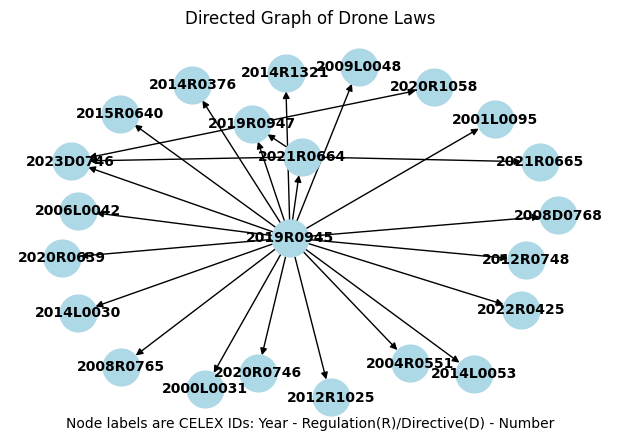

In [248]:
# Load the JSON data
with open("data/drone_laws/g_dronelaws_1.json") as f:
    data = json.load(f)

# Create a directed graph
g_drones1 = nx.DiGraph()

# Add nodes
for node in data['nodes']:
    g_drones1.add_node(node['id'])
# Add edges
for link in data['links']:
    g_drones1.add_edge(link['source'], link['target'])

# Visualize the graph
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(g_drones1) 
nx.draw(g_drones1, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
plt.title("Directed Graph of Drone Laws")
plt.figtext(0.5, 0.01, "Node labels are CELEX IDs: Year - Regulation(R)/Directive(D) - Number", 
             wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

Visualizations can even be misleading. The three plots below represent the exact same network (image from Wallis 2007, page 7). If one asks "which node is the most central one?" in relation to this particular network, the drawing on the left probably provides us the most insight and the one on the right is highly misleading (all the nodes in this network are equally central).

![image](images/ch1/equivalent_viz.png)

## 2.4 Bipartite Graphs

Networks typically deal with relations between a single class of entities, that is to say, the nodes are of the same type, they belong to the same class. For example, we may be interested in citations between cases, friendship between persons, similarity between documents and so forth. In these examples, the entities within the classes used to measure citations, friendship, and similarity are the same.

Yet sometimes it is interesting to consider the relationship between two different types of elements. We might want to research, for example, patterns of treaty ratification. Modelling this requires working with two types of nodes: states and treaties. This implies the creation of a bipartite network, where edges connect nodes of a different type. These sorts of networks are sometimes also called affilation networks. Below you can see an example of such a bipartite graph.

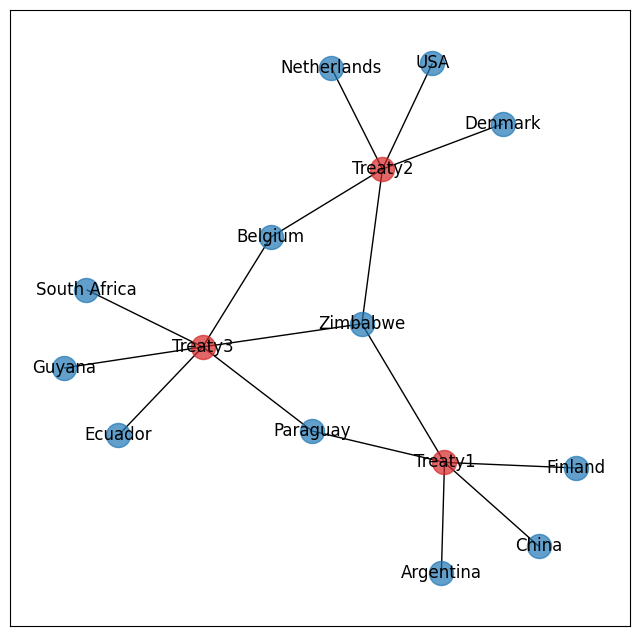

In [122]:
g_treaties = load_graph_from_json("data/g_treaties.json")
states = [x[0] for x in list(g_treaties.nodes(data="bipartite")) if x[1] == 0]
treaties = [x[0] for x in list(g_treaties.nodes(data="bipartite")) if x[1] == 1]
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_treaties, seed=123)
nx.draw_networkx_nodes(g_treaties, pos=pos, nodelist= states, node_color='tab:blue', alpha = 0.7)
nx.draw_networkx_nodes(g_treaties, pos=pos, nodelist= treaties, node_color='tab:red', alpha =0.7)
nx.draw_networkx_edges(g_treaties, pos=pos)
nx.draw_networkx_labels(g_treaties, pos=pos);

The drone network that was initially created in the research was not a bipartite network. We can, however, create one by adding information on the types of laws to the previous network. Nodes 2019R0945, 2019R0947, 2021R0664, and 2021R0665 are drone-specific laws, meaning that they consist of rules that specifically apply to drones. In contrast, the other laws include rules that may be relevant to drones but are not specifically drafted with drones in mind. Think of rules on aviation or perhaps privacy or cybersecurity. The visualization shows which laws are considered drone-specific legislation and which ones are not.

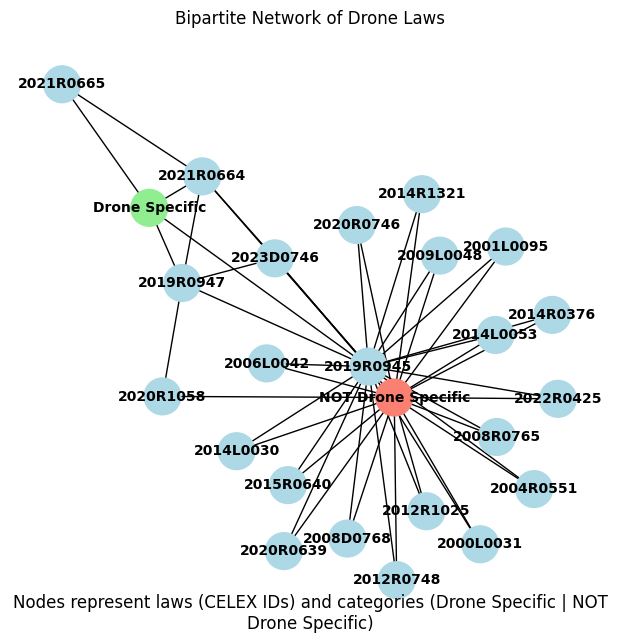

In [123]:
# Load the JSON data
with open("data/drone_laws/g_dronelaws_1.json") as f:
    data = json.load(f)

# Create a bipartite graph
B = nx.Graph()

# Define drone-specific and general-purpose laws
drone_specific_laws = {"2019R0947", "2021R0664", "2021R0665", "2019R0945"}
general_purpose_laws = set()

# Add nodes for laws and categories
for node in data['nodes']:
    law_id = node['id']
    B.add_node(law_id)  # Add law nodes
    if law_id in drone_specific_laws:
        B.add_node("Drone Specific")  # Add drone-specific category node
        B.add_edge(law_id, "Drone Specific")  # Connect law to its category
    else:
        B.add_node("NOT Drone Specific")  # Add general-purpose category node
        B.add_edge(law_id, "NOT Drone Specific")  # Connect law to its category
        general_purpose_laws.add(law_id)

# Add edges from the original links to the bipartite graph
for link in data['links']:
    source = link['source']
    target = link['target']
    B.add_edge(source, target)

# Define colors for categories and laws
law_color = 'lightblue'         # Color for law nodes
category_color = {'Drone Specific': 'lightgreen', 'NOT Drone Specific': 'salmon'}  # Colors for categories

# Create lists for node colors
node_colors = []
for node in B.nodes():
    if node in category_color:  # If it's a category node
        node_colors.append(category_color[node])
    else:
        node_colors.append(law_color)  # Law nodes color

# Visualize the bipartite graph
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(B)  # Positions for all nodes

# Draw the graph with specified colors
nx.draw(B, pos, with_labels=True, node_size=700, node_color=node_colors, font_size=10, font_weight='bold', arrows=False)
plt.title("Bipartite Network of Drone Laws")
plt.figtext(0.5, 0.01, "Nodes represent laws (CELEX IDs) and categories (Drone Specific | NOT Drone Specific)", 
             wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

## 2.5 Directed Acyclic Graph (DAG)

Another special type of graph is a directed acyclic graph or DAG. A DAG is a directed graph that has no cycles or loops, hence it is 'acyclic'.

Citation networks, which are often used in legal network analysis, should in theory be DAGs. In case law citation networks, for instance, newer cases will cite older cases and not the other way around. Likewise, cases are unlikely to cite themselves. As a result, there should in theory be no loops in case citation networks. In practice, however, this does not always hold. Loops may occur, for instance if two cases cite that both been written around the same time cite one another.
Our drone legislation example is also a DAG. It is directed, because one law cites another, it is acyclic, because more recent legislation cites less recent legislation and not the other way around, and it is a graph that consists of nodes and edges.

DAGs are important in some areas of research. For example, DAGs are used to model causal processes, on the understanding that causation is always linear and undirectional. To illustrate, we draw a toy example of a casual model that predicts a country will ratify a free trade treaty if the country is democratic, has a liberal government, has high unemployment, and a high percentage of young citizens. 

Notice that, in this model, the relationship is directional and not cyclic (once the free trade treaty is ratified, this does not, in turn, make it more likely that democracy will prevail).

This work does not delve further into DAGs.

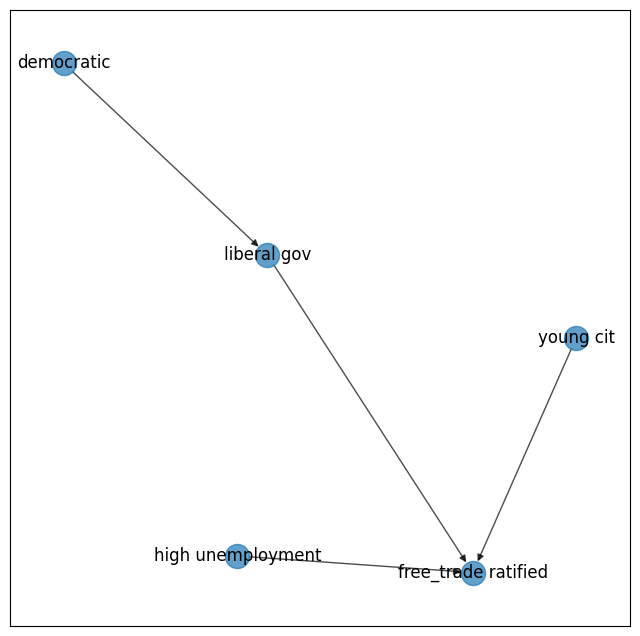

In [124]:
g_dag = nx.DiGraph()
g_dag.add_edge("democratic", "liberal gov")
g_dag.add_edge("liberal gov", "free_trade ratified")
g_dag.add_edge("young cit", "free_trade ratified")
g_dag.add_edge("high unemployment", "free_trade ratified")

draw_spring(g_dag)

## 2.6 Trees

There are many types of trees. An intuitive one is the "rooted tree", which parallels what we may naively understand as a tree: graphs without loops with a single root node to which all the other nodes are connected (directly or indirectly). 

Trees can have a parameter controlling in how many segments they branch out, and another controlling their height or depth, that is in this case, how far away the furthest leaf is from the root. Here we can see a binary tree of height 3.

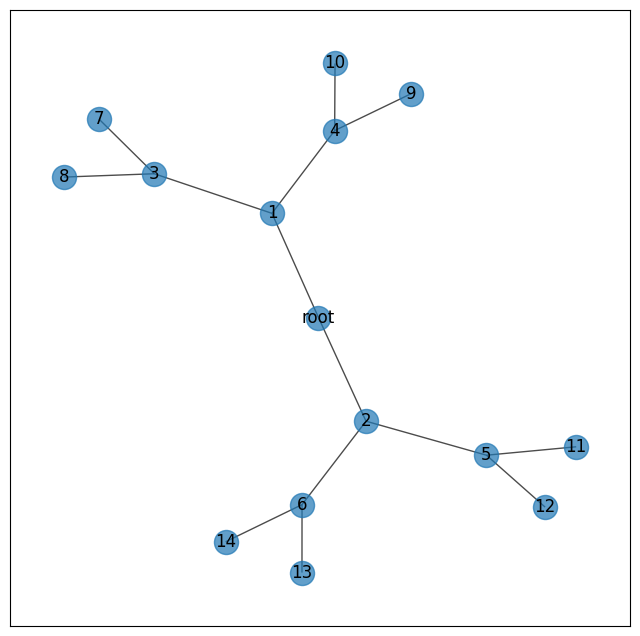

In [125]:
g_tree = nx.Graph()
g_tree.add_nodes_from(["root", 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
g_tree.add_edges_from([("root",1),("root",2),(1,3),(1,4),(2,5),(2,6),(3,7),(3,8),
                       (4,9),(4,10),(5,11),(5,12),(6,13),(6,14)])
draw_spring(g_tree)

Trees can be directed or undirected. Directed trees can flow from the root out towards the leaves, or vice versa, flow from the leaves into the root. Trees are not necessarily rooted.  

There is a great variety of trees, and the tree data structure is widely used by many disciplines. This work does not delve further into trees.

## 2.7 Graphs versus Networks

Graphs and networks are sometimes used interchangeably. However, the terms point to different aspects of the graph structure and to different fields of study. 

At the graph level, it is irrelevant wether the nodes and edges represent friendship relations, connections between subway stations, or participation in a criminal organization. The focus is on the nodes and edges are considered abstractly. Graph theory is a field of mathematics that explores the abstract properties of graphs.

Networks are based on graphs (hence on nodes and edges), but they are used to study concrete relationships between entities: treaty ratifications by states, citations between court cases, similarity between documents, etc. Moreover, the nodes and edges can be enriched with even more information (which may be called metadata, see Chapter 2, sections 5 and 6). For example, if nodes consist of documents, a network might record the language of the documents, the name of the authors, the year of publication, etc.


## 2.8 Power Law Distribution

Networks frequently have a Power Law distribution. A Power Law distribution entails that the frequency distributions of network properties are highly skewed. For example, it is common in legal network analysis, particularly the analysis of citation networks, that a few nodes have a very high number of edges and most nodes a small number of edges. We illustrate this by means of a network of  Court of Justice of the European Union (CJEU) case law, where the source nodes consist of cases that are labeled as 'consumer protection'. With source nodes, we mean the cases that were searched and for which the citations in those cases were harvested. In this network, the cases are the nodes and the references in and to the cases the edges. The network consists of 1,614 nodes (cases) and 2,662 edges (references).

Below, we plot the distribution of incoming citations among the cases by means of a histogram. The horizontal axis shows the number of incoming citations and the vertical axis the number of cases. The results reveal that a relatively small number of cases have a relatively high number of incoming citations (the sparse right tail of the histogram recording 40 or more citations), whereas there are a lot of cases that are hardly ever, if at all, cited (the towering bar recording cases with around 0 citations).


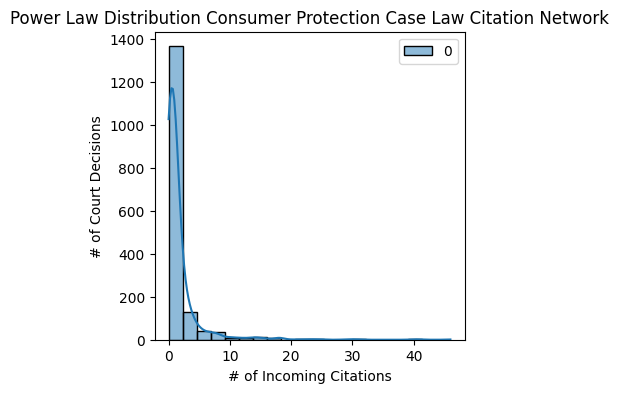

In [133]:
g_consprot = load_graph_from_json("data/g_consprot.json")
plt.figure(figsize=(4,4))
plt.title("Power Law Distribution Consumer Protection Case Law Citation Network")
plt.xlabel("# of Incoming Citations") #add label
plt.ylabel("# of Court Decisions") #add label
sns.histplot(dict(g_consprot.in_degree).values(), stat="count", bins=20, kde=True); 

We can also observe a power law distribution in our drone legislation example. Cleary, the vast majority of laws hardly have citations, whereas a small number of laws have a substantial number of citations.

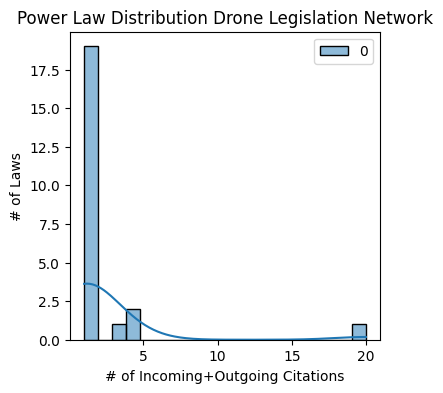

In [139]:
plt.figure(figsize=(4,4))
plt.title("Power Law Distribution Drone Legislation Network")
plt.xlabel("# of Incoming+Outgoing Citations") #add label
plt.ylabel("# of Laws") #add label
sns.histplot(dict(G_drones1.degree).values(), stat="count", bins=20, kde=True); 

>Here we show both incoming and outgoing citations while in the consumer protection network we focused on incoming citations. The reason for this difference is that the drone legislation network has many laws that are cited at least once, but very few that are not cited at all. This happens because of how we built the network. We started with one law and then tracked all the references made to and from that law. As a result, the network includes many laws that have been cited at least once.

'Law' in power law distributions refers to something akin to a 'law of nature'. It does not have anything to do with the law as in norms or rules. Rather, a power law distribution is an empirical fact of certain networks such as citation networks or social networks. 

Power Law distributions often have the effect of preferential attachment: Ihe nodes with many edges are likely to receive more edges (e.g., citations) in the future for the mere fact that they already had many edges before. This is also called the 'rich get richer' effect.

## 2.9 Node Degree and Node Centrality

Network analysis is a method to capture how central a node is in a network. This centrality can be an indicator of, for instance, the popularity or relevance of a node in a network.

We will discuss different metrics such as Degree Centrality, Closeness Centrality and Betweeness Centrality in more detail in Chatper 3 of this manual. For now, it key to note that there may be more than one way of being 'central'. Intuitively compare nodes 3, 5 and 7 in the Krackhard kite graph below. Which one is the most important?

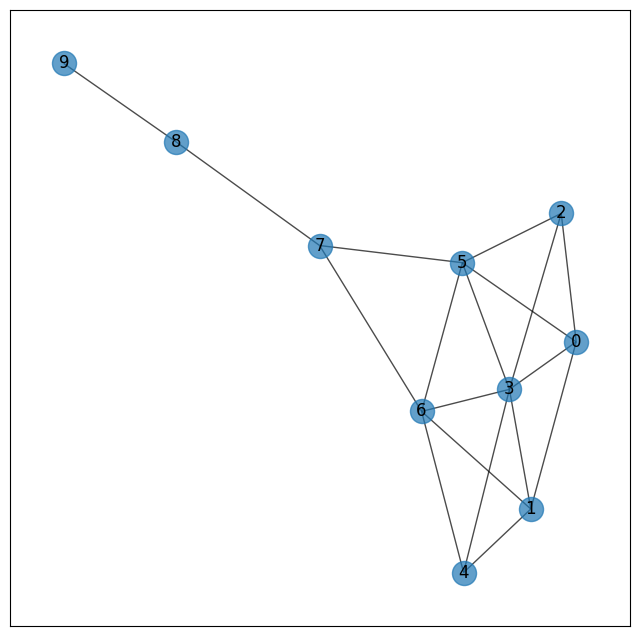

In [140]:
g_kite = nx.krackhardt_kite_graph()
draw_spring(g_kite)

The answer to this question depends on how 'importance' is operationalized. If we define importance as the node with the most connections, node 3 (six edges) and perhaps nodes 5 and 6 (five edges each) come to mind. However, node 3 is rather far removed from other nodes in the network, such as nodes 8 and 9. It takes three steps to reach node 8 and four steps to reach node 9 from node 3. From this perspective, nodes 5 and 6 might be considered more important, as we can reach most nodes in one step, some in two, and one in three steps. Another way to look at importance is to focus on the nodes that 'glue' the network together. In the kite graph, removing node 7 would result in nodes 8 and 9 being disconnected from the rest of the network. To a lesser extent, node 8 also causes a disconnect.

We can do a similar exercise for our drone network. Here we can observe that node 2019R0945 is the most connected node in terms of 'glue', number of direct neighbors, and shortest paths to other nodes in the network. Node 2021R0664 is also well-connected, but to a much lesser extent than node 2019R0945.

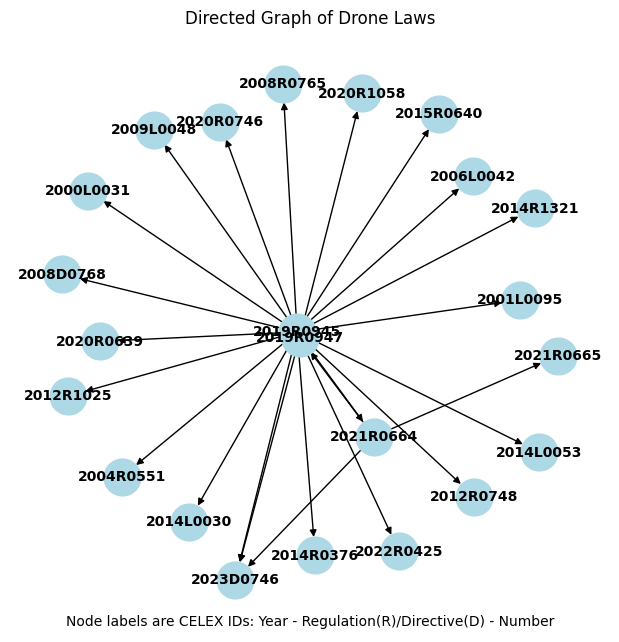

In [253]:
# Visualize the graph
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(g_drones1) 
nx.draw(g_drones1, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
plt.title("Directed Graph of Drone Laws")
plt.figtext(0.5, 0.01, "Node labels are CELEX IDs: Year - Regulation(R)/Directive(D) - Number", 
             wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

>Selecting node 2019R0945 as a starting point for the network construction makes it likely a central node in the resulting network. This will become more clear when explain the concept of ego networks below.

There are many different ways to look at importance (in network analysis terminology: centrality). We will return to this in subsequent chapters.

## 2.10 Community Detection

Network analysis allows for the detection of communities in networks, which are sometimes also called 'cliques'  or 'clusters'. 

The idea behind community detection is to group together nodes that are tightly connected to each other. In most scenarios, that means that the level of connection within the nodes of a particular community will be higher than outside of it. 

Nodes that belong to the same community are likely to share common attributes or functions, and they often possess different properties than the larger network.

<img src="images/ch1/community_detection.png" alt="drawing" width="250"/>

Various algorithms exist to detect communities. The Girvan-Newman Algorithm, Label Propagation Communities and Louvain Communities will be explored in Chapter 4. Nevertheless, we can already provide an idea of what the clustering looks like. The plot shows two clusters, one around 2019R945, the other one around other drone-specific legislation (e.g., 2019R947, 2021R664, 2021R665) and laws related to that legislation.

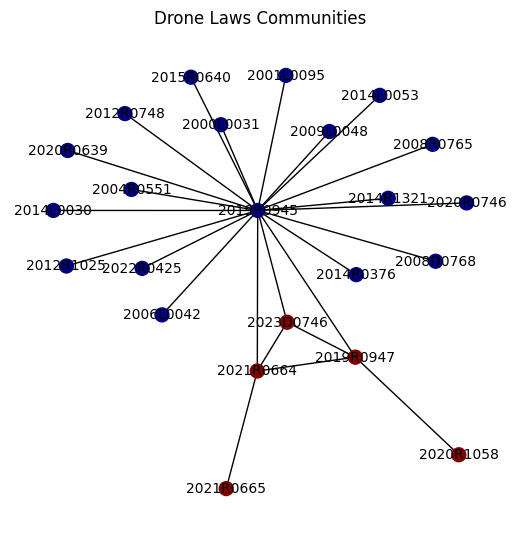

In [182]:
# Load the JSON data
with open("data/drone_laws/g_dronelaws_1.json") as f:
    data = json.load(f)
# Create a directed graph from the data
g_dag = nx.DiGraph()
# Add nodes
for node in data['nodes']:
    g_dag.add_node(node['id'])
# Add edges
for link in data['links']:
    g_dag.add_edge(link['source'], link['target'])
# Convert to undirected graph for community detection
g_undirected = g_dag.to_undirected()
# Detect communities using the greedy modularity method
communities = community.greedy_modularity_communities(g_undirected)
# Create a color map for the communities
color_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        color_map[node] = i
# Draw the graph
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(g_undirected)  # positions for all nodes
# Draw nodes with colors based on their community
node_colors = [color_map[node] for node in g_undirected.nodes()]
nx.draw(g_undirected, pos, with_labels=True, node_color=node_colors, 
        node_size=100, font_size=10, cmap=plt.cm.jet)
# Show the plot
plt.title("Drone Laws Communities")
plt.show()

It may be argued it is not necessary to detect communities in such a relatively small network. We therefore expand the network. In the network above, we included references in source node 2019R0945, references to the source node, and references to the references to the source node. In our new network, we select two source nodes with drone-specific legislation (2019R0945 and 2021R0664). Furthermore, we include in the network references in the two source nodes, the references in the references that are in the source node, and the references *to* one of the two source nodes. The network we obtain includes many more nodes. A closer inspection would reveal clusters of legislation that deal with a variety of topics, ranging from clusters with drone-specific legislation to clusters with avation-specific laws to a cluster with privacy legislation.

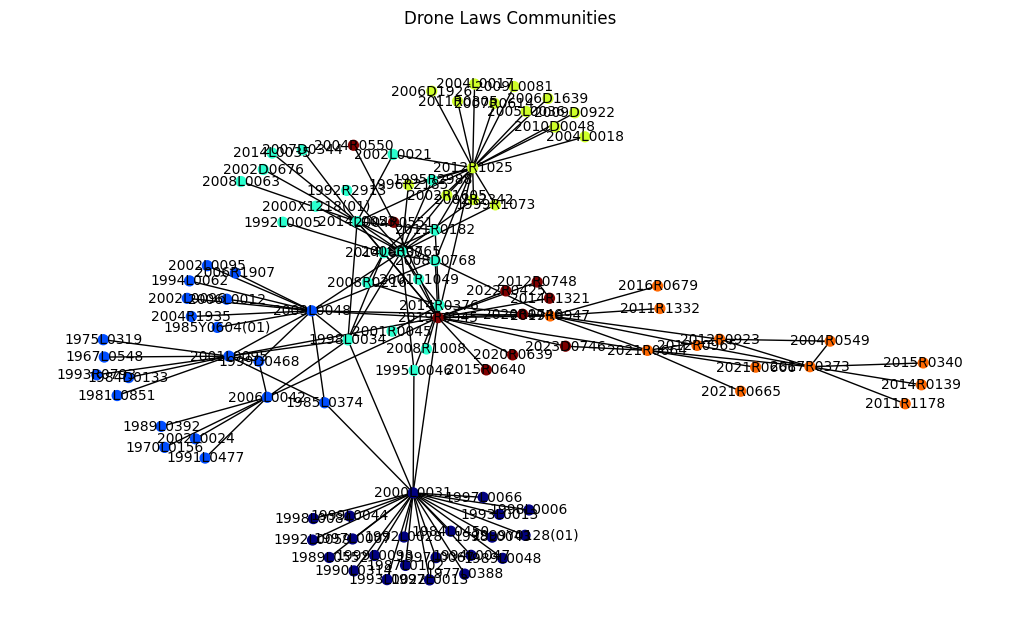

In [266]:
# Load the JSON data
with open("data/drone_laws/g_dronelaws_2.json") as f:
    data = json.load(f)
# Create a directed graph from the data
g_dag = nx.DiGraph()
# Add nodes
for node in data['nodes']:
    g_dag.add_node(node['id'])
# Add edges
for link in data['links']:
    g_dag.add_edge(link['source'], link['target'])
# Convert to undirected graph for community detection
g_undirected = g_dag.to_undirected()
# Detect communities using the greedy modularity method
communities = community.greedy_modularity_communities(g_undirected)
# Create a color map for the communities
color_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        color_map[node] = i
# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(g_undirected)  # positions for all nodes
# Draw nodes with colors based on their community
node_colors = [color_map[node] for node in g_undirected.nodes()]
nx.draw(g_undirected, pos, with_labels=True, node_color=node_colors, 
        node_size=50, font_size=10, cmap=plt.cm.jet)
# Show the plot
plt.title("Drone Laws Communities")
plt.show()

## 2.11 Paths, Shortest Paths, and Distance between Nodes

A path is a series of steps getting from node A to node B. For any node of the network, it is possible to calculate the path it has to other nodes (if such a path exists) and its distance. The distance is the number of steps, or the number of steps weighted by any relevant weight metric. 

Some complications deserve mention here, which are further discussed below:

* Disconnected nodes
* Fully connected networks
* Shortest path
* Weighted paths
* Random paths
* Eccentricity and network diameter

### Disconnected Nodes

It is not guaranteed that there will be a path between two nodes. It is possible that two sets of nodes are simply not connected. In this case there is no path between the nodes, directly or indirectly. This situation can be observed in the example below, where nodes A, B, and C, are disconnected from nodes D and E.

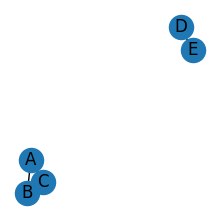

In [267]:
g_disconnected = nx.Graph()
g_disconnected.add_nodes_from(['A','B','C','D','E'])
g_disconnected.add_edges_from([('A','B'),('B','C'), ('C','A'),('D','E')])
plt.figure(figsize=(2, 2))  # Adjust the figure size (width, height)
nx.draw_spring(g_disconnected, with_labels=True)
plt.show()

### Fully connected networks

A network is fully connected if every node is connected to every other node. To see how this will look consider these graphs from Wolfram (https://mathworld.wolfram.com/CompleteGraph.html)

![image](images/ch2/wolfram.png)

A fully connected network will have a fixed number of edges as a function of how many nodes it has. That is, for every node $n$ a fully connected network will have $ \frac{n(n-1)}{2} $ edges. Note that for such networks it would be pointless to try to distinguish between nodes using measures like centrality or community, unless the edges have differing weights.

It is not always possible to tell visually if a network is fully connected , as one can see from the network below (which with 25 nodes, remains small). In such cases machines can test the full-connectedness of a network.

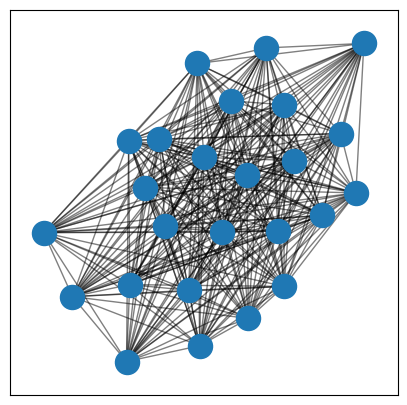

In [268]:
g_distances = load_graph_from_json("data/g_distances.json")
plt.figure(figsize=(5,5))
pos = nx.spring_layout(g_distances, seed=121)

nx.draw_networkx_nodes(g_distances, pos)
nx.draw_networkx_edges(g_distances, pos=pos, edge_color='black', alpha=0.5)

In [269]:
nx.is_connected(g_distances)

True

We can also test this for our initial drone legislation example. Because this network is a directed network, there are two ways to determine whether the network is fully connected. A first way is by ignoring the direction of the edges (thereby assuming an undirected network). This is called testing whether the network is *weakly* connected. As we could see above in the network visualization, the network is fully (weakly) connected.

In [270]:
print("The network is weakly connected:", nx.is_weakly_connected(g_drones1))

The network is weakly connected: True


A *strongly* connected network takes the direction of the edges into consideration. Strongly connected means there is a path between any two nodes in both directions. Put differently, there is a path from $u$ to $v$ and a path from $v$ to $u$ for any two nodes $u$ and $v$. The drone legislation network is not strongly connected. We could have expected this. A strongly connected network implies there are cycles - how else could there both be a path from $u$ to $v$ and from $v$ to $u$. Because we already concluded the drone legislation network is a DAG, we can infer from this that it cannot be strongly connected.

In [271]:
print("The network is weakly connected:", nx.is_strongly_connected(g_drones1))

The network is weakly connected: False


### Shortest paths

The shortest path is the path that will reach a node in the smallest number of steps. There can be more than one "shortest path" (but all the shortest paths will have the same smallest number of steps). For example, if we look at the kite graph, there are two shortest paths from 7 to 3, one going through 6, and another going through 5. There are longer paths too, for example, 7 -> 5 -> 2 -> 3. These may not be immediately relevant, but might be interesting possible random paths, between 7 and 3.

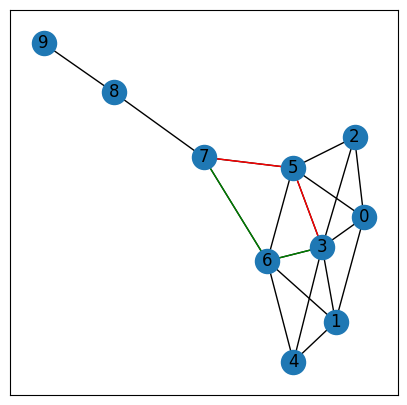

In [272]:
g_kite = nx.krackhardt_kite_graph()
plt.figure(figsize=(5,5))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos)
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_edges(g_kite, edgelist=[(7,5),(5,3)], edge_color="red", pos=pos)
nx.draw_networkx_edges(g_kite, edgelist=[(7,6),(6,3)], edge_color="green", pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

While shortest paths can be easy to 'see' in small graphs like this one, this will not be possible in more complex graphs. Finding the shortest path will then be a non-trivial problem. This process is automated by network analysis libraries and programs. We use this automation to find the shortest paths in the drone legislation network.



In [273]:
# Select source and target node
NodeA = '2019R0945'
NodeB = '2021R0665'
# For shortest path lengths between all pairs of nodes
shortest_paths_lengths = dict(nx.shortest_path_length(g_drones1))
# Print the shortest path length from one specific node to another
print("Shortest path between", NodeA, "and", NodeB, ":", nx.shortest_path_length(g_drones1, source=NodeA, target=NodeB))

Shortest path between 2019R0945 and 2021R0665 : 2


>Note that because the network is directed, there is no path, and therefore no shortest path, from 2019R0945 to 2021R0665.

Shortest paths are useful for many purposes. In the context of this presentation, it will be seen that they are key ingredients in many algorithms for identifying the most important or most central nodes of a network.

For the unweighted graphs that we are using, a shortest path counts discrete 'steps' between nodes. This implies that all the nodes are a unit distance away. However, it is also possible to have weighted paths, as we will discuss later. 

### Random paths

The length of the shortest path will be a definite number. However, there may be a large or arbitrary number of non-shortest paths wandering through the nodes. 

A single arbitrary path will not be of much interest (why this one?, why not another one?), but if we allow movement randomly from node to node, these random paths - random walks - can become useful (unless the random walk get 'stuck' in a loop). We may be interested not only in the shortest path between A and B, but in the average path distance between A and B, taking into account routes that go more or less directly from A to B as well as those that make longer detours. By measuring a number of random walks for a number of nodes in the network, it will often become clear that some nodes are more likely to be passed through than other nodes, which suggests these nodes are more central and perhaps therefore more relevant or interesting.

We illustrate the shortest path with a coding example. We create a random path with the neighbors attribute of the Graph object. The steps are more or less like this:

1. Select a number of steps for the walk. In this case four steps. Execute the tasks below until you hit four steps.
2. Select a particular node to start with, for example node 7.
3. Find all the neighbors of node 7 (in this case, 5, 6, 8).
4. Randomly choose one of these nodes to go to. Say choose node 5.
5. Update the value of your start position to the chosen node, in this case 5.
6. Record that you have made one step (3 to go).
7. If you have made less than four steps, go back to step 2. If you have made four steps, stop.

These steps can be implemented in code as follows:

In [274]:
# here we are limiting the number of steps to 4, we get 5 steps in the answer because the answer includes the start node, and n is initialized at 0.

n = 0
start = 7
history = [start]
while n < 4:
  my_neighbors = list(g_kite.neighbors(start))
  move_to_node = np.random.choice(my_neighbors)
  history.append(move_to_node.tolist())
  start = move_to_node
  n += 1

print(history)

[7, 6, 7, 6, 5]


Most likely we will not be interest in a single random path, but in lots of them, and they can be generated in bulk.

In [275]:
random_paths = nx.generate_random_paths(g_kite, sample_size=10, path_length=4)
for i in random_paths:
    print(i)

[8, 9, 8, 7, 5]
[3, 0, 5, 2, 3]
[9, 8, 9, 8, 7]
[1, 0, 3, 5, 2]
[9, 8, 7, 5, 0]
[2, 3, 2, 3, 1]
[1, 3, 6, 1, 6]
[9, 8, 9, 8, 7]
[5, 2, 5, 7, 5]
[8, 7, 8, 9, 8]


Or, for the drone legislation example:

In [276]:
# Get the list of all nodes in the graph
nodes = list(g_drones1.nodes())  # Ensure you use .nodes() to get the nodes from the graph

# Generate 10 random paths
random_paths = []
for _ in range(10):
    # Randomly select source and target nodes
    source, target = random.sample(nodes, 2)  # Ensure source and target are different

    try:
        # Find the shortest path between the random nodes
        path = nx.shortest_path(g_drones1, source=source, target=target)
        random_paths.append(path)
    except nx.NetworkXNoPath:
        # If no path exists between the selected nodes, skip or handle it as needed
        print(f"No path between {source} and {target}")
        continue

# Print the random paths
for i, path in enumerate(random_paths):
    print(f"Random Path {i+1}: {path}")

No path between 2014R0376 and 2014R1321
No path between 2012R0748 and 2004R0551
No path between 2006L0042 and 2009L0048
No path between 2001L0095 and 2014L0030
No path between 2014L0030 and 2014R1321
No path between 2021R0665 and 2008R0765
No path between 2014R0376 and 2019R0947
No path between 2008D0768 and 2019R0947
No path between 2014R0376 and 2015R0640
Random Path 1: ['2019R0945', '2020R0746']


### Weighted edges

An edge can show that there is a relationship between nodes A and B. The nature of that relationship can be many things, such as there being a train between A and B, or that case A cites case B. In these instances the relationship is binary: There either is a connection or there is not.

However, there is a range of cases where one wants to record the strength of a connection and not just its presence. For example, one might want to record not only that there is train path from A to B but also how long that path is in terms of kilometers. We might want to score not only that case A cites case B but also how many times case B is cited by case A. We can add this attribute to the edge by giving weights to edges. For instance, if case A cites case B four times, the edge weight becomes four.

Weighted networks can be represented visually in an intuitive way by using different colors or line styles for their edges. Below is a network using a document similarity matrix. This matrix records how close two documents are in light of the tokens they share (Jaccard distance) and scores them with 1 if they are identical, and 0 if they are completely different. It is made of a set of ECHR Grand Chamber judgments on the extraterritorial application of fundamental rights. 

In the process of comparing the distance between each document, this dataframe is turned into a matrix, and that can be used to build a network. Please see Appendix 1: "Text Similarity Networks" for more details of how this can be done. 

The purpose of this example is to show that if you graph the network without consideration of weight, it gives you a fully connected network, which is a nice geometrical figure, but not very informative. Every document was compared to every other document, so every node is on step (one degree) of separation from every other and so every node has the exact same number of neighbors.

A more informative network structure can be shown if we take consideration of weight. One way to do this is to pick only the edges whose weight meets a certain test. Here we are simply whose weight surpases the mean weight plus one standard deviation.

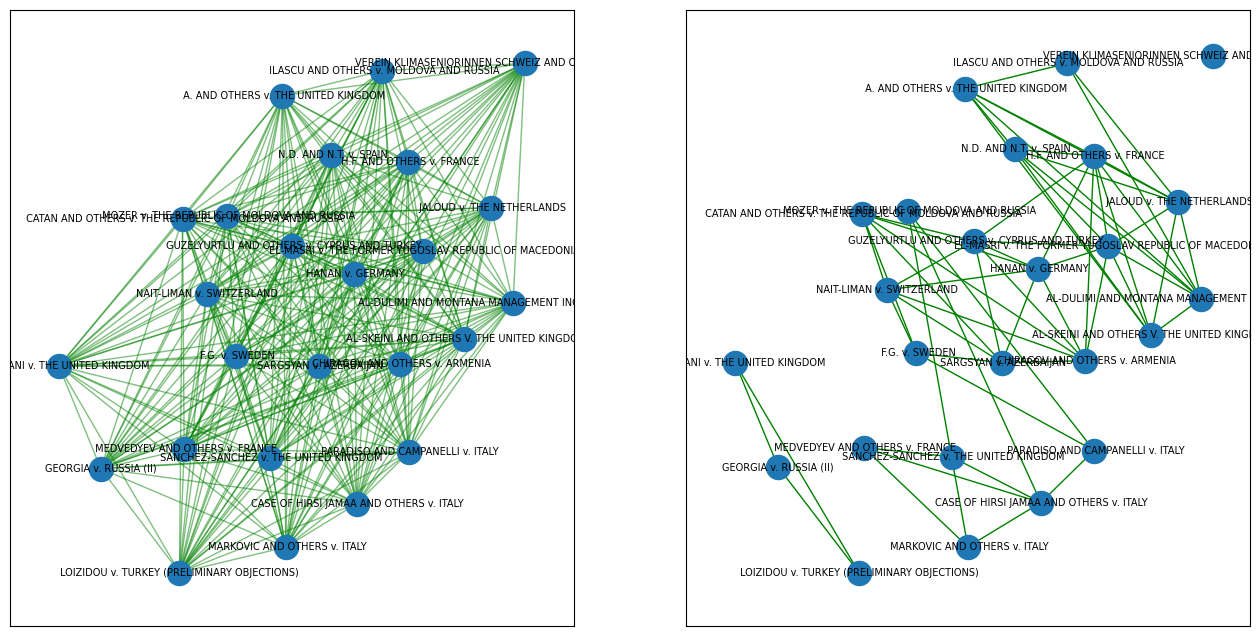

In [277]:
g_distances = load_graph_from_json("data/g_distances.json")
mean_simil = np.mean([z for x,y,z in g_distances.edges.data("weight")])
std_mimil = np.std([z for x,y,z in g_distances.edges.data("weight")])

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
pos = nx.spring_layout(g_distances, seed=121)


nx.draw_networkx_nodes(g_distances, pos, ax=ax[0])
nx.draw_networkx_edges(g_distances, pos=pos, edge_color='green', ax=ax[0], alpha=0.5)
nx.draw_networkx_labels(g_distances, pos=pos, font_size=7, ax = ax[0]);

nx.draw_networkx_nodes(g_distances, pos, ax=ax[1])
lowweight = [e for e in g_distances.edges if g_distances.edges[e]['weight'] < mean_simil+std_mimil]
highweight = [e for e in g_distances.edges if g_distances.edges[e]['weight'] > mean_simil+std_mimil]
nx.draw_networkx_edges(g_distances, edgelist=highweight, pos=pos, edge_color='green', ax=ax[1])
nx.draw_networkx_labels(g_distances, pos=pos, font_size=7, ax = ax[1]);

We stated that assessing centrality or community of fully connected networks can be pointless, for all the nodes are then by definition connected to all the other nodes, and so they will get identical scores. However, in weighted networks it is not pointless to assess the centrality or community of its nodes, because the edges have different weights. This is illustrated in the section on closeness centrality below.

Calculating shortest paths is different for weighted edges than for unweighted edges. In unweighted graphs it would be a matter of counting the steps on different paths and finding the one with the lowest number of steps, whereas in weighted graphs the procedure is to count the steps and multiply every step by its weight.

Also note that the weight can represent closeness or distance. If it represents distance, then one must simply multiply by it. If it represents closeness, we need to convert it into distance by using its reciprocal.

$$ distance = \frac{1}{closeness} $$ 

### Network Density

Recall the fully connected networks discussed earlier:

![image](images/ch2/wolfram.png)

Since every node here will be connected to every other node (there are no strangers, everyone is a neighbor of everyone else, everyone has maximum popularity) it can be said that these networks are maximally dense.

A maximally dense network will have $ \frac{n(n-1)}{2} $ edges. Consequently, a network with 3 nodes can have a maximum of 3 edges, a network with 4 nodes 6 edges, a network with 5 nodes 10 edges, and so forth.

The network density will be the ratio of the number of edges actually present $ m $ to the hypothetical maximum, in other words:

$$ \frac{m}{n(n-1)/2} $$

Using this formula, we can calculate the density of our drone legislation network. The density is fairly low (.10), which coincides with a visual inspection of the network, where we can observe that nodes are frequently connected to one other node but not to other nodes. Consequently, the number of actual edges to a node is far less than the number of possible edges to other nodes.

In [278]:
n = g_drones1.number_of_nodes()
m = g_drones1.number_of_edges()

if n > 1:
    density = m / (n * (n - 1) / 2)
else:
    density = 0  # The density of a graph with 1 or 0 nodes is defined as 0

print("Density of the graph:", density)


Density of the graph: 0.09881422924901186


### Eccentricity and Network Diameter

Next we need to consider eccentricity. Eccentricity records the longest shortest path between
every node. In the kite graph above, we can see that the eccentricity of node 9 is 4, as the maximum shortest path that exist between that node and some other node is four steps. Node 7, by contrast, has a maximum eccentricity of 2, as the longest shortest path that exist between it any other node is just 2.

Just as we can be interested in what is the center of a network, we can be interested in how large the network is. However, one cannot just 'eye' a network graph to get a sense of its dimensions, because a graph can be plotted in many different ways and still be the same network.

The diameter of a network is very simple to calculate. It is just the maximum eccentricity value. A network is as wide as the longest shortest path that it includes. For the kite network, no node is further away than four steps from any other (that is the longest shortest path) and thus that is its diameter.

In [279]:
print("Diameter of the connected graph:", nx.diameter(g_kite))

Diameter of the connected graph: 4


We can also perform the calculation for the drone legislation network. Because this network is a directed network, we will first convert it to an undirected network, which makes the interpretation more straightforward.

In [280]:
# Create a weakly connected version of the graph
g_weak = g_drones1.to_undirected()
# Calculate the diamater
print("Diameter of the weakly connected graph:", nx.diameter(g_weak))

Diameter of the weakly connected graph: 3


## 2.12 Ego Networks

One important type of subgraph is the ego network, which is centered on one particular node (the 'ego' or self) and then contains only those nodes that have a path to the ego within a given radius. That is to say, we can see only the nodes that are a defined number of steps away from the ego.

The drone legislation example is an ego network. This is the result of the way in which it was construed. By including all references in the a specific node (node 2019R0945), the references to the node, and the references to the references to the node, the resulting network is one that is centered around the source node (node 2019R0945).

An ego network can be useful to zoom in on one particular set of relations. For example, using the karate club graph we can use ego networks to see all the nodes that are one step away from the karate instructor (node 33 in the networkx version of the dataset).

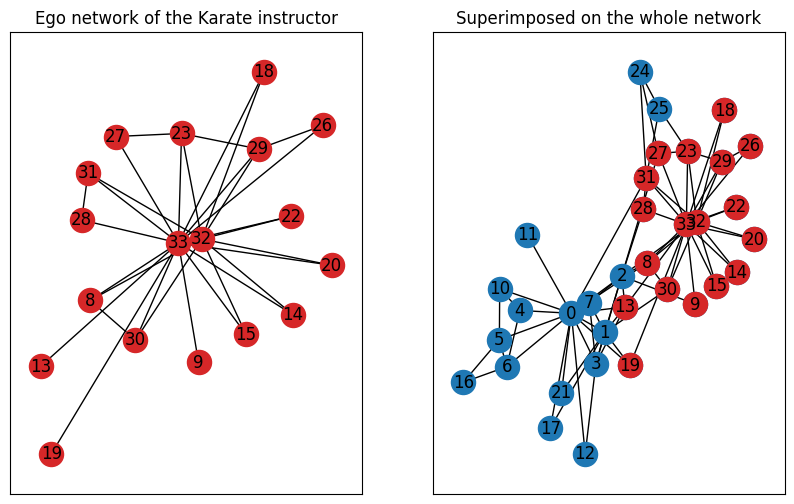

In [281]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
g_karate = nx.karate_club_graph()
ego_karate = nx.ego_graph(g_karate, 33)
pos = nx.spring_layout(g_karate, seed=123)
nx.draw_networkx_nodes(ego_karate, pos=pos, ax=ax[0], node_color="tab:red")
nx.draw_networkx_labels(ego_karate, pos=pos, ax=ax[0])
nx.draw_networkx_edges(ego_karate, pos=pos, ax=ax[0])
nx.draw_networkx_nodes(g_karate, pos=pos, ax=ax[1])
nx.draw_networkx_nodes(ego_karate, pos=pos, node_color="tab:red", ax=ax[1])
nx.draw_networkx_labels(g_karate, pos=pos, ax=ax[1])
nx.draw_networkx_edges(g_karate, pos=pos, ax=ax[1])
ax[0].set_title("Ego network of the Karate instructor")
ax[1].set_title("Superimposed on the whole network");